In [37]:
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize the Google Earth Engine
ee.Initialize()

# Define the region of interest (ROI) - Sudan boundaries
roi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Sudan'))

# Define the date range
start_date = '2018-01-01'
end_date = '2024-12-31'

terra = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_date, end_date)
)
aqua = (
    ee.ImageCollection("MODIS/061/MYD13Q1")
    .select(["EVI", "SummaryQA", "DetailedQA"])
    .filterDate(start_date, end_date)
)

modis = terra.select("EVI").merge(aqua.select("EVI"))
modis = modis.sort("system:time_start")

#----------------------BITWISE MASKING---------------------------------------
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None:
        toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


# Applying the SummaryQA  and DetailedQA
def modisQA_mask(image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    # viUsefulnessFlagsD = bitwiseExtract(dqa, 2, 5)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    viShadowFlagsD = bitwiseExtract(dqa, 15)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    # .And(viShadowFlagsD).eq(0); # No shadow
    return image.updateMask(mask)


mod13q1_QC = terra.map(modisQA_mask)
myd13q1_QC = aqua.map(modisQA_mask)

mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
mxd13q1_cleaned_sorted = mxd13q1_cleaned.sort("system:time_start")

bool_dict = {
    "0": "ocean",
    "1": "non_crop",
    "2": "crop_irrigated",
    "3": "crop_rainfed",
}

#Applying DEA Cropmask
dea = ee.ImageCollection(
    "projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/mask"
).mosaic()
crop_data_dea = dea.select("b1").rename("crop").clip(roi)
crop_data_viz_dea = crop_data_dea.mask(crop_data_dea.gt(0))


scale_factor = 0.0001

# apply cropland mask to imageCollection
def cropmask(img):
    return img.updateMask(crop_data_dea).clip(roi)  # .multiply(scale_factor) # unmask(-1)


mxd13q1 = mxd13q1_cleaned_sorted.map(cropmask)
#masked_modis = modis.map(cropmask)

# Filter the collection by date and region
#filtered_evi = modis_evi.filterDate(start_date, end_date).filterBounds(roi)

# Function to scale the EVI values
def scale_evi(image):
    return image.multiply(0.0001).copyProperties(image, ["system:time_start"])

scaled_evi = mxd13q1.map(scale_evi)

In [38]:
scaled_evi

In [27]:

# Function to calculate yearly EVI time series
def calculate_yearly_evi(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)
    yearly_collection = scaled_evi.filterDate(start, end)
    evi_mean = yearly_collection.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=500,
        maxPixels=1e9
    )
    return ee.Feature(None, {'year': year, 'mean_ndvi': evi_mean.get('NDVI')})



In [ ]:
# Loop through each year and calculate yearly EVI
years = list(range(2018, 2025))
evi_values = [calculate_yearly_evi(year).getInfo()['properties'] for year in years]

# Plot the EVI time series
plt.figure(figsize=(10, 6))
plt.plot([item['year'] for item in evi_values], [item['mean_ndvi'] for item in evi_values], marker='o', label='Mean NDVI')
plt.title('Mean NDVI Time Series for Sudan (2018-2024)')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.legend()
plt.grid()
plt.show()



In [5]:
'''#Define phenology metrics calculation functions
def get_phenology_metrics(image):
    # Smooth the EVI curve (Savitzky-Golay filter can be used for smoothing)
    evi_array = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=roi,
        scale=500,
        maxPixels=1e9
    ).get('NDVI')

    evi_values = np.array(ee.Array(evi_array).getInfo())
    
    # Phenological analysis logic
    sos_index = np.argmax(evi_values > 0.3)  # Start of Season when EVI crosses 0.3 threshold
    eos_index = len(evi_values) - np.argmax(np.flipud(evi_values) > 0.3) - 1  # End of Season
    peak_index = np.argmax(evi_values)  # Peak Vegetation
    
    # Extract dates using indices
    dates = np.linspace(datetime(year, 1, 1).toordinal(), datetime(year, 12, 31).toordinal(), len(evi_values))
    sos_date = datetime.fromordinal(int(dates[sos_index]))
    eos_date = datetime.fromordinal(int(dates[eos_index]))
    peak_date = datetime.fromordinal(int(dates[peak_index]))

    # Length of the growing season
    length_of_season = (eos_date - sos_date).days
    
    # Metrics dictionary
    metrics = {
        'SOS': sos_date,
        'EOS': eos_date,
        'Peak': peak_date,
        'Length_of_Season': length_of_season,
        'Max_NDVI': evi_values[peak_index]
    }
    return metrics

# Example: Extract phenology metrics for the year 2023
year = 2023
yearly_evi_image = scaled_evi.filterDate(f'{year}-01-01', f'{year}-12-31').mean()
phenology_metrics = get_phenology_metrics(yearly_evi_image)
print(f"Phenology metrics for {year}: {phenology_metrics}")'''


Phenology metrics for 2023: {'SOS': datetime.datetime(2023, 1, 1, 0, 0), 'EOS': datetime.datetime(2023, 11, 20, 0, 0), 'Peak': datetime.datetime(2023, 7, 10, 0, 0), 'Length_of_Season': 323, 'Max_EVI': np.float64(0.6029978260869566)}


In [39]:
def get_evi_time_series(year, roi):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    
    evi_filtered = mxd13q1.filterDate(start_date,end_date).filterBounds(roi)
    
    # Map a function over the collection to extract the mean EVI for each image
    def calculate_mean_evi(image):
        mean_evi = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=500,
            maxPixels=1e9
        )
        # Add a date property
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'mean_evi': mean_evi.get('EVI')
        })
    
    # Apply the function to each image in the collection
    evi_features = evi_filtered.map(calculate_mean_evi).getInfo()

    # Convert the result to a list of dates and mean EVI values
    dates = []
    mean_evi_values = []
    for f in evi_features['features']:
        # Ensure that 'properties' and 'mean_evi' exist
        properties = f.get('properties', {})
        mean_evi = properties.get('mean_evi')
        if mean_evi is not None:
            dates.append(properties.get('date', 'Unknown Date'))
            mean_evi_values.append(mean_evi)
    
    return dates, mean_evi_values

# Get EVI time series data for the year 2023
dates, mean_evi_values = get_evi_time_series(2023, roi)

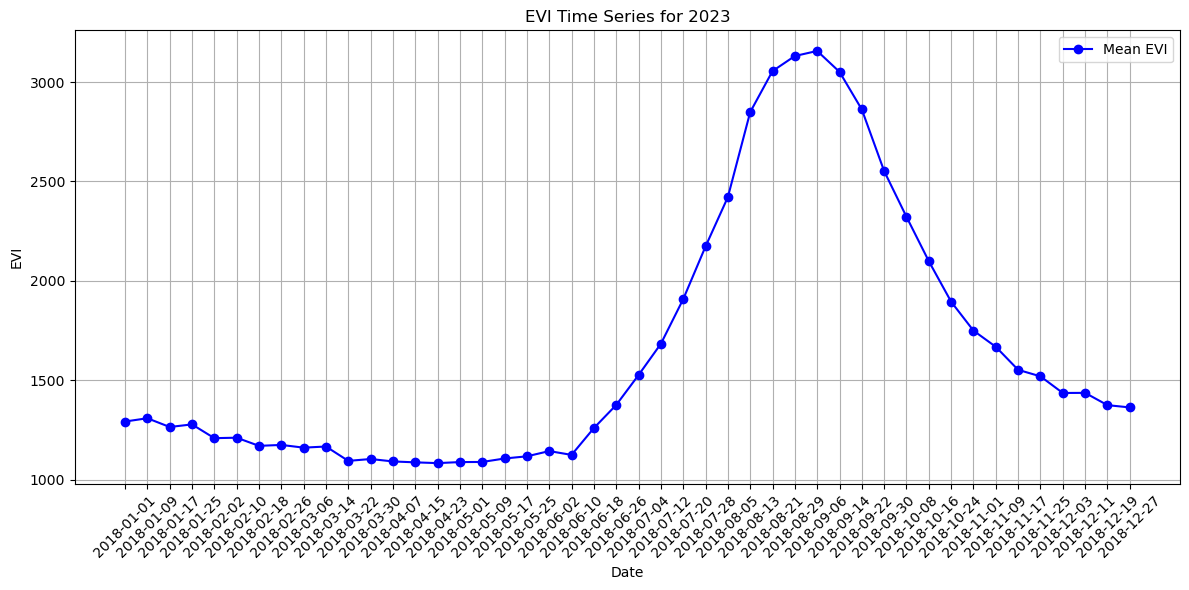

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(dates, mean_evi_values, marker='o', linestyle='-', color='b', label='Mean EVI')
plt.title('EVI Time Series for 2018')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


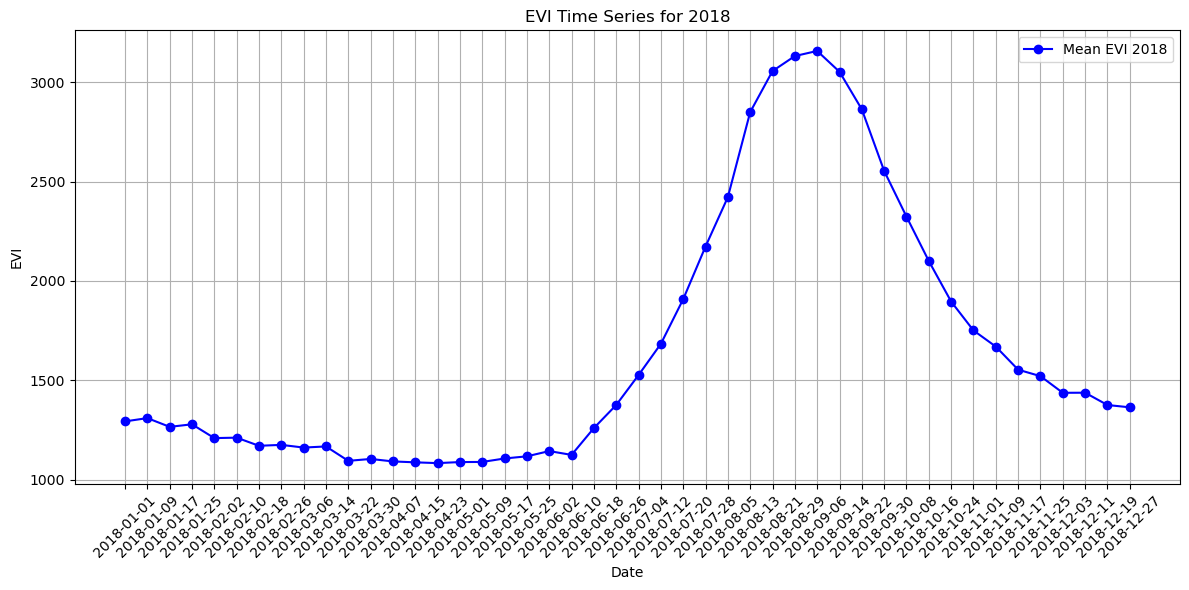

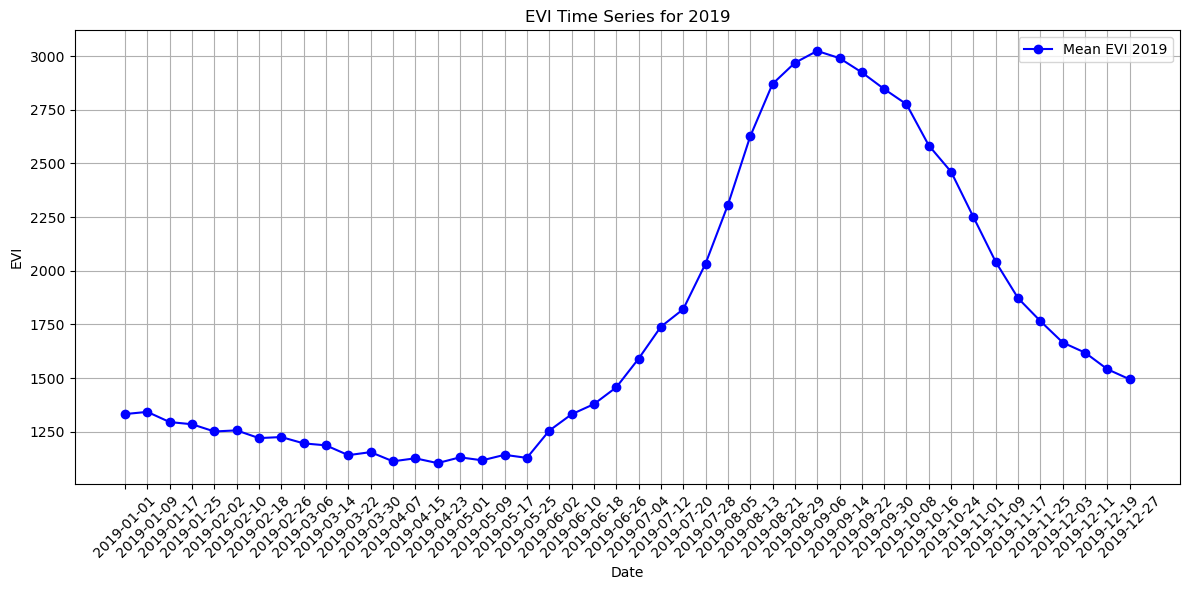

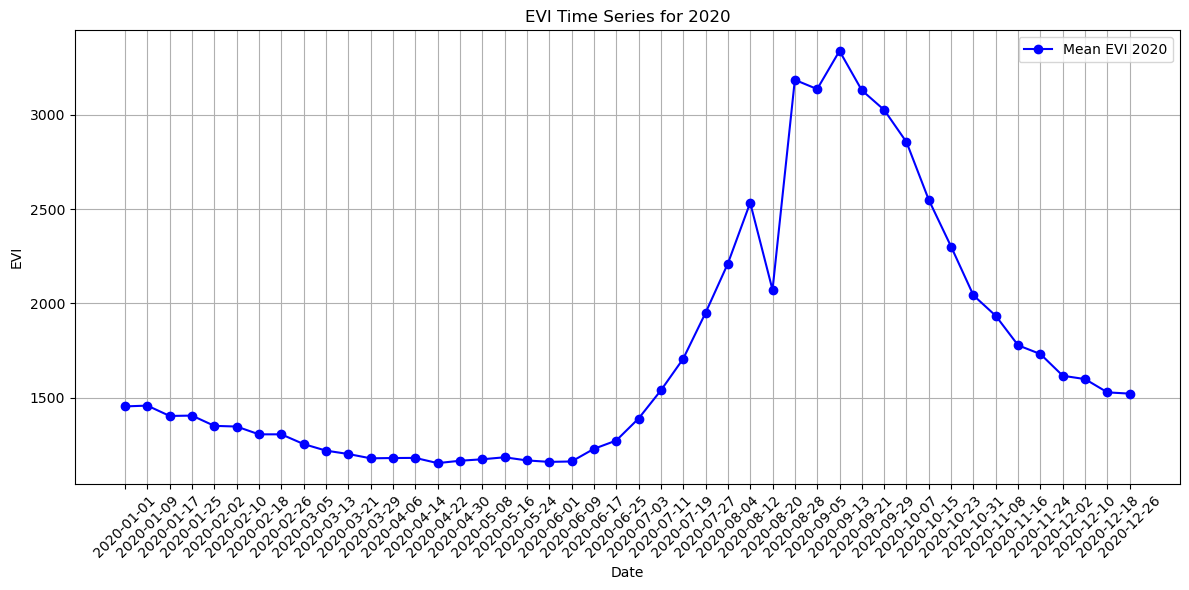

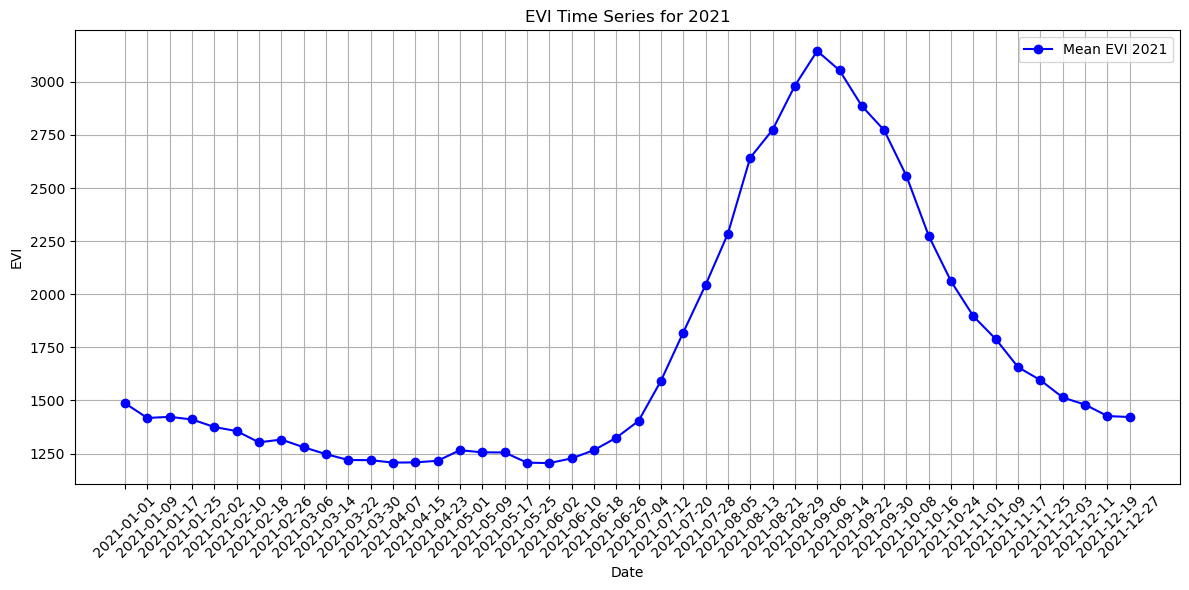

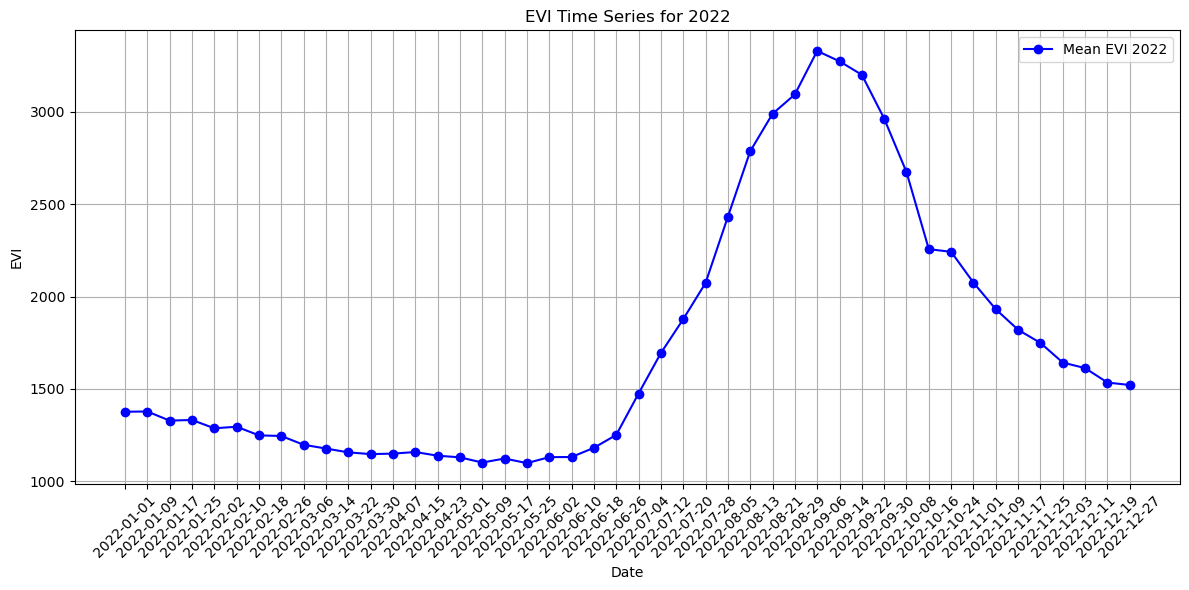

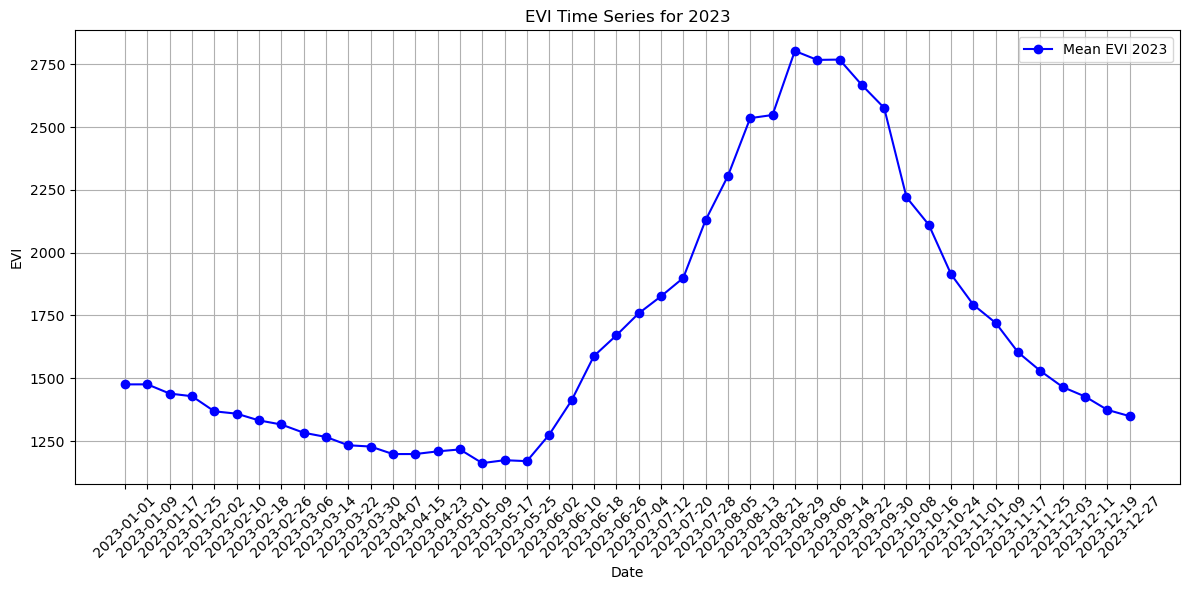

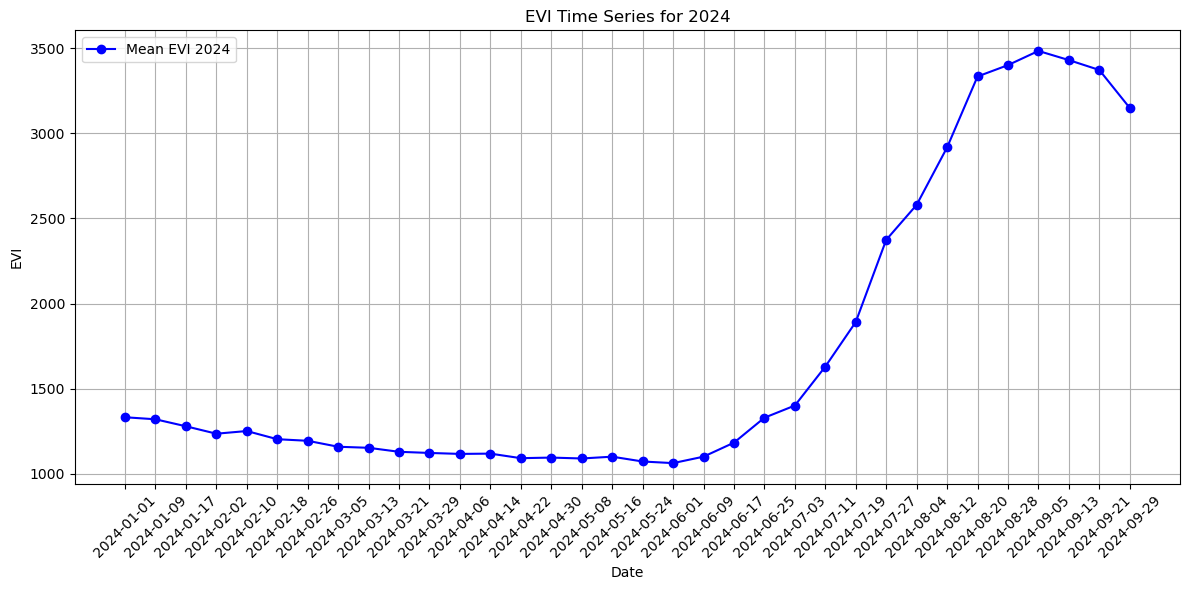

In [40]:
# List of years to plot
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Generate separate plots for each year
for year in years:
    # Get EVI time series data for the current year
    dates, mean_evi_values = get_evi_time_series(year, roi)
    
    # Create a new figure for each year
    plt.figure(figsize=(12, 6))
    
    # Plot the EVI time series for the current year
    plt.plot(dates, mean_evi_values, marker='o', linestyle='-', color='b', label=f'Mean EVI {year}')
    
    # Add title and labels
    plt.title(f'EVI Time Series for {year}')
    plt.xlabel('Date')
    plt.ylabel('EVI')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    # Show the plot for the current year
    plt.show()